# Importing Necessary Libraries and Settings

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import median
from bs4 import BeautifulSoup
import requests
import urllib.request, urllib.parse, urllib.error
import json
import warnings; warnings.filterwarnings(action='once')
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
pd.set_option('mode.chained_assignment', None)

large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}

plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
%matplotlib inline

# Obtaining Box Office Data
1.  Importing Data from .csv Files

In [2]:
data_folder = 'zippedData/'

data_files = [
    'bom.movie_gross.csv.gz',
    'imdb.title.basics.csv.gz',
    'tn.movie_budgets.csv.gz',
]

# Storing Data into DataFrames
df = []
for i in range(len(data_files)):
    df.append(pd.read_csv(data_folder + data_files[i]))

# Removing and Adjusting Datatype of Columns in df[0]
df[0].drop(['studio', 'year'], axis=1, inplace=True)
df[0]['domestic_gross'] = pd.to_numeric(df[0]['domestic_gross'],
                                        errors='coerce')
df[0]['foreign_gross'] = pd.to_numeric(df[0]['foreign_gross'], errors='coerce')
df[0].head()

# Removing and Renaming Columns in df[1]
df[1].drop(['tconst', 'original_title', 'start_year', 'runtime_minutes'], 
           axis=1, inplace=True)
df[1] = df[1].rename(columns={'primary_title': 'title'})

# Removing, Renaming, and Adjusting Datatype of Columns in df3
df[2].drop(['id'], axis=1, inplace=True)
df[2]['release_date'] = pd.to_datetime(df[2]['release_date'])
df[2].sort_values('release_date', inplace = True)
df[2] = df[2].rename(columns={'movie': 'title'})
df[2][df[2].columns[2:]] = df[2][df[2].columns[2:]
                                ].replace('[\$,]', '', regex=True).astype(float)
df[2] = df[2][df[2]['release_date'].dt.year >= 2010]

In [3]:
df[0].head()

,title,domestic_gross,foreign_gross
0,Toy Story 3,415000000.0,652000000.0
1,Alice in Wonderland (2010),334200000.0,691300000.0
2,Harry Potter and the Deathly Hallows Part 1,296000000.0,664300000.0
3,Inception,292600000.0,535700000.0
4,Shrek Forever After,238700000.0,513900000.0


In [4]:
df[1].head()

,title,genres
0,Sunghursh,"Action,Crime,Drama"
1,One Day Before the Rainy Season,"Biography,Drama"
2,The Other Side of the Wind,Drama
3,Sabse Bada Sukh,"Comedy,Drama"
4,The Wandering Soap Opera,"Comedy,Drama,Fantasy"


In [5]:
df[2].head()

,release_date,title,production_budget,domestic_gross,worldwide_gross
2812,2010-01-08,Youth in Revolt,18000000.0,15285588.0,19685588.0
2739,2010-01-08,Leap Year,19000000.0,25918920.0,32618920.0
2566,2010-01-08,Daybreakers,20000000.0,30101577.0,51445503.0
2067,2010-01-15,The Spy Next Door,28000000.0,24307106.0,46752858.0
4735,2010-01-15,Fish Tank,3000000.0,374675.0,5922292.0


2.  Web-Scraping Data from "The Numbers"

In [6]:
# Making Soup to Extract Movies, Rekease Dates, Genres, and Gross

numbers_url = {}

for year in range(2010, 2020):
    numbers_url[year] = (
        'https://www.the-numbers.com/market/%s/top-grossing-movies' % year)
numbers_response = {}
for year in range(2010, 2020):
    numbers_response[year] = requests.get(numbers_url[year])
numbers_soup = {}
for year in range(2010, 2020):
    numbers_soup[year] = BeautifulSoup(numbers_response[year].text, 'lxml')

In [7]:
# Finding Containers

# Container with Table
numbers_warning = {}
for year in range(2010, 2020):
    numbers_warning[year] = numbers_soup[year].find('table')

# Container with General Information
numbers_con = {}
for year in range (2010, 2020):
    numbers_con[year] = numbers_warning[year].find_all('tr')

In [8]:
# Scraping Data

numbers_movies = []
numbers_dates = []
numbers_genres = []
numbers_gross = []

# Function for Tags
def data_pull1 (data,index):
        phrase = data.find_all('td', class_='data')[index].get_text()
        phrases = phrase.split('$')[1]
        return int(phrases.replace(',',''))

for year in range (2010, 2020):
    for a in range(1, len(numbers_con[year])-2):
        numbers_movies.append(numbers_con[year][a].find_all('a')[0].get_text())
        numbers_dates.append(numbers_con[year][a].find_all('a')[1].get_text())
        numbers_gross.append(data_pull1(numbers_con[year][a],1))
      
        try:
            numbers_genres.append(
                numbers_con[year][a].find_all('a')[3].get_text())
        except:
            numbers_genres.append(None)

In [9]:
# Making More Soup to Extract Domestic, Foreign, and Worldwide Gross

pages = []
pagesetup = 1
while pagesetup <= 6001:
    pages.append(pagesetup)
    pagesetup +=100

morenumbers_url = {}
for page in pages:
    morenumbers_url[page] = (
        'https://www.the-numbers.com/movie/budgets/all/%s' % page)
morenumbers_url[1] = 'https://www.the-numbers.com/movie/budgets/all'

morenumbers_response = {}
for page in pages:
    morenumbers_response[page] = requests.get(morenumbers_url[page])

    morenumbers_soup = {}
for page in pages:
    morenumbers_soup[page] = BeautifulSoup(morenumbers_response[page].text,
                                           'lxml')

In [10]:
# Finding Containers

# Container with Table
morenumbers_warning = {}
for page in pages:
    morenumbers_warning[page] = morenumbers_soup[page].find('table')

# Container with General Information
morenumbers_con = {}
for page in pages:
    morenumbers_con[page] = morenumbers_warning[page].find_all('tr')

In [11]:
# Scraping Data

morenumbers_movies = []
morenumbers_production = []
morenumbers_domestic = []
morenumbers_worldwide = []

# Function for Tags
def data_pull2(data,index):
        phrase = data.find_all('td', class_='data')[index].get_text()
        phrases = phrase.split('$')[1]
        return int(phrases.replace(',',''))

for page in pages:
    for a in range(1, len(morenumbers_con[page])):
        morenumbers_movies.append(morenumbers_con[page]
                                  [a].find_all('a')[1].get_text())
        morenumbers_production.append(data_pull2(morenumbers_con[page][a],1))
        morenumbers_domestic.append(data_pull2(morenumbers_con[page][a],2))
        morenumbers_worldwide.append(data_pull2(morenumbers_con[page][a],3))

In [12]:
# Storing Web-Scraped Data into DataFrames
numbers_df = pd.DataFrame([numbers_dates, numbers_movies,
                           numbers_genres, numbers_gross]).transpose()
numbers_df.columns = ['release_date', 'title',  'genres', 'domestic_gross']

morenumbers_df = pd.DataFrame([morenumbers_movies, 
                               morenumbers_production, 
                               morenumbers_domestic,
                               morenumbers_worldwide]).transpose()
morenumbers_df.columns = ['title', 'production_budget', 
                          'domestic_gross', 'worldwide_gross']
morenumbers_df['foreign_gross'] = (morenumbers_df['worldwide_gross'] 
                                   - morenumbers_df['domestic_gross'])

# Merging the DataFrames
mergednumbers_df = numbers_df.merge(morenumbers_df, on='title', how='left')
mergednumbers_df['domestic_gross'] = mergednumbers_df[['domestic_gross_x','domestic_gross_y']].max(axis=1)
mergednumbers_df.drop(['domestic_gross_x', 'domestic_gross_y'], axis=1, inplace=True)
mergednumbers_df['release_date'] = pd.to_datetime(mergednumbers_df['release_date'], errors='coerce')

df_columns = ['release_date', 'title', 'genres', 
              'production_budget', 'domestic_gross', 
              'foreign_gross', 'worldwide_gross']

mergednumbers_df = mergednumbers_df.reindex(columns=df_columns)
mergednumbers_df.sort_values('release_date', inplace = True)
mergednumbers_df.head()

,release_date,title,genres,production_budget,domestic_gross,foreign_gross,worldwide_gross
5301,1926-01-07,Moana,Documentary,150000000,248757044.0,387679108,636436152
984,1927-03-13,Metropolis,Action,15000000,673414.0,731618,1405032
1866,1938-09-12,La Grande Illusion,None,NaN,71641.0,NaN,NaN
5291,1942-12-25,Arabian Nights,Adventure,NaN,3719.0,NaN,NaN
7506,1945-11-30,Detour,Drama,NaN,1540.0,NaN,NaN


3. Obtainig API Data via "IMDb"

In [13]:
API_key = '294f4c0e6d0861470f47e84017c8e2c1'

In [14]:
# Obtaining List of Movies for Given Year with vote_count Filter

def API_search(year,vote_count):
    #This request pulls the first page of the search request
    resp = requests.get('https://api.themoviedb.org/3/discover/movie?api_key=' 
                        + str(API_key) + '&language=en-US&vote_count.gte='
                        + str(vote_count) + '&primary_release_year='
                        + str(year))
    data_p1 = dict(resp.json())

    # Finding Number of Pages in Search and Adding to DataFrame 
    search_pages = data_p1['total_pages']
    data = pd.DataFrame.from_dict(data_p1['results'])
    url = ('https://api.themoviedb.org/3/discover/movie?api_key=' 
           + str(API_key) + '&language=en-US&vote_count.gte='
           + str(vote_count) + '&primary_release_year=' + str(year) +'&page=')
    for page in range(2,search_pages+1):
        resp = requests.get(url + str(page))
        temp = dict(resp.json())
        df_by_page = pd.DataFrame.from_dict(temp['results'])
        data = pd.concat([data,df_by_page], ignore_index=True)

    data = data.set_index('id')
    # Storing movies in list
    return data.index.values.tolist()

In [15]:
# Creating List of Movies (2010-2019)

movies_index = []

vote_count = 1000
search_years = list(range(2010,2020))

for year in search_years:
    movies_index = movies_index + API_search(year,vote_count)
    
movies_index[:5]

[27205, 12444, 10138, 10193, 11324]

In [16]:
#Testing API Request Data  

resp = requests.get('https://api.themoviedb.org/3/movie/' 
                    + str(movies_index[0]) + '?api_key=' + str(API_key))
dict(resp.json())

{'adult': False,
 'backdrop_path': '/s3TBrRGB1iav7gFOCNx3H31MoES.jpg',
 'belongs_to_collection': None,
 'budget': 160000000,
 'genres': [{'id': 28, 'name': 'Action'},
  {'id': 878, 'name': 'Science Fiction'},
  {'id': 12, 'name': 'Adventure'}],
 'homepage': 'http://inceptionmovie.warnerbros.com/',
 'id': 27205,
 'imdb_id': 'tt1375666',
 'original_language': 'en',
 'original_title': 'Inception',
 'overview': 'Cobb, a skilled thief who commits corporate espionage by infiltrating the subconscious of his targets is offered a chance to regain his old life as payment for a task considered to be impossible: "inception", the implantation of another person\'s idea into a target\'s subconscious.',
 'popularity': 72.287,
 'poster_path': '/9gk7adHYeDvHkCSEqAvQNLV5Uge.jpg',
 'production_companies': [{'id': 923,
   'logo_path': '/5UQsZrfbfG2dYJbx8DxfoTr2Bvu.png',
   'name': 'Legendary Entertainment',
   'origin_country': 'US'},
  {'id': 9996,
   'logo_path': '/3tvBqYsBhxWeHlu62SIJ1el93O7.png',
   'n

In [17]:
# Defining Function to Arrange Data into Dictionary for Given Movie

def API_request(movie):
    resp = requests.get('https://api.themoviedb.org/3/movie/' + str(movie) 
                        + '?api_key=' + str(API_key))
    if resp.status_code == requests.codes.ok:
        temp = dict(resp.json())
        movie = {}
        movie['imdb_id'] = temp['imdb_id']
        movie['popularity'] = temp['popularity']
        movie['release_date'] = pd.to_datetime(temp['release_date'])
        movie['genres'] = [genre['name'] for genre in temp['genres']]
        movie['title'] = temp['title']
        movie['budget'] = int(temp['budget'])
        movie['revenue'] = int(temp['revenue'])
        movie['runtime_mins'] = temp['runtime']
        movie['vote_average'] = temp['vote_average']        
        movie['vote_count'] = temp['vote_count']   
        return movie

In [18]:
# Testing API_request per Movie
print(API_request(movies_index[0]))

{'imdb_id': 'tt1375666', 'popularity': 72.287, 'release_date': Timestamp('2010-07-15 00:00:00'), 'genres': ['Action', 'Science Fiction', 'Adventure'], 'title': 'Inception', 'budget': 160000000, 'revenue': 825532764, 'runtime_mins': 148, 'vote_average': 8.3, 'vote_count': 26575}


In [19]:
# LONG RUNTIME #

# Make requests to the API for the movie data
imbd_API_data = list(map(lambda x: API_request(x),movies_index))

In [20]:
# Creating DataFrame of Data Obtained
imdb_raw_df = pd.DataFrame.from_dict(imbd_API_data)
imdb_df = pd.DataFrame.from_dict(imbd_API_data)

# Testing Data Retrieval and Consistency

In [21]:
# .csv Imports
df[2][df[2]['title'] == 'Alice in Wonderland']

,release_date,title,production_budget,domestic_gross,worldwide_gross
50,2010-03-05,Alice in Wonderland,200000000.0,334191110.0,1.025491e+09


In [22]:
# Web-Scraping
mergednumbers_df[mergednumbers_df['title'] == 'Alice in Wonderland']

,release_date,title,genres,production_budget,domestic_gross,foreign_gross,worldwide_gross
3,2010-03-05,Alice in Wonderland,Adventure,3000000,334191110.0,0,0
2,2010-03-05,Alice in Wonderland,Adventure,200000000,334191110.0,691300000,1025491110


In [23]:
# API
imdb_df[imdb_df['title'] == 'Alice in Wonderland']

,imdb_id,popularity,release_date,genres,title,budget,revenue,runtime_mins,vote_average,vote_count
12,tt1014759,21.536,2010-03-03,"[Family, Fantasy, Adventure]",Alice in Wonderland,200000000,1025467110,108,6.6,10386


# Merging DataFrames

In [24]:
# Merging .csv Import DataFrames (df1 and df2)
merged_df1 = pd.merge(df[0], df[1], how='outer', on='title')

# Merging df3 to df1/df2
merged_df2 = pd.merge(merged_df1, df[2], how='outer', on='title')

# Editting NaN Values for Easier Merging and Data Analysis
merged_df2['domestic_gross'] = merged_df2[['domestic_gross_x',
                                           'domestic_gross_y']].max(axis=1)
merged_df2.drop(['domestic_gross_x', 'domestic_gross_y'], axis=1, inplace=True)
merged_df2.dropna(subset=['release_date'], inplace = True)

merged_df2.head()

,title,foreign_gross,genres,release_date,production_budget,worldwide_gross,domestic_gross
0,Toy Story 3,652000000.0,"Adventure,Animation,Comedy",2010-06-18,200000000.0,1.068880e+09,415004880.0
3,Inception,535700000.0,"Action,Adventure,Sci-Fi",2010-07-16,160000000.0,8.355246e+08,292600000.0
4,Shrek Forever After,513900000.0,"Adventure,Animation,Comedy",2010-05-21,165000000.0,7.562447e+08,238736787.0
5,The Twilight Saga: Eclipse,398000000.0,"Adventure,Drama,Fantasy",2010-06-30,68000000.0,7.061028e+08,300531751.0
6,Iron Man 2,311500000.0,"Action,Adventure,Sci-Fi",2010-05-07,170000000.0,6.211564e+08,312433331.0


In [25]:
# Merging .csv Imports data with Web-Scraped Data
merged_df3 = pd.merge(merged_df2, mergednumbers_df, how='outer', on='title')
merged_df3.drop(['release_date_x'], axis=1, inplace=True)
merged_df3 = merged_df3.rename(columns={'release_date_y': 'release_date'})
merged_df3.head()

,title,foreign_gross_x,genres_x,production_budget_x,worldwide_gross_x,domestic_gross_x,release_date,genres_y,production_budget_y,domestic_gross_y,foreign_gross_y,worldwide_gross_y
0,Toy Story 3,652000000.0,"Adventure,Animation,Comedy",200000000.0,1.068880e+09,415004880.0,2010-06-18,Adventure,200000000,415004880.0,653874642,1068879522
1,Inception,535700000.0,"Action,Adventure,Sci-Fi",160000000.0,8.355246e+08,292600000.0,2010-07-16,Thriller/Suspense,160000000,292576195.0,539975766,832551961
2,Inception,535700000.0,"Action,Adventure,Sci-Fi",160000000.0,8.355246e+08,292600000.0,2010-07-16,Thriller/Suspense,160000000,292576195.0,539975766,832551961
3,Shrek Forever After,513900000.0,"Adventure,Animation,Comedy",165000000.0,7.562447e+08,238736787.0,2010-05-21,Adventure,165000000,238736787.0,517507886,756244673
4,The Twilight Saga: Eclipse,398000000.0,"Adventure,Drama,Fantasy",68000000.0,7.061028e+08,300531751.0,2010-06-30,Drama,68000000,300531751.0,405571077,706102828


In [26]:
def max_value(dataframe,column_name):
       
    dataframe[column_name] = dataframe[[column_name 
                                        + '_x',column_name
                                        + '_y']].max(axis=1)
    dataframe.drop([column_name + '_x',column_name 
                    + '_y'], axis=1, inplace=True)
    
    return dataframe

In [27]:
# Condensing/Cleaning Numerical Columns

columns_max_value = ['foreign_gross', 'production_budget','worldwide_gross',
                     'domestic_gross']

for column in columns_max_value:
    max_value(merged_df3, column)

merged_df3.head()

,title,genres_x,release_date,genres_y,foreign_gross,production_budget,worldwide_gross,domestic_gross
0,Toy Story 3,"Adventure,Animation,Comedy",2010-06-18,Adventure,653874642.0,200000000.0,1.068880e+09,415004880.0
1,Inception,"Action,Adventure,Sci-Fi",2010-07-16,Thriller/Suspense,539975766.0,160000000.0,8.355246e+08,292600000.0
2,Inception,"Action,Adventure,Sci-Fi",2010-07-16,Thriller/Suspense,539975766.0,160000000.0,8.355246e+08,292600000.0
3,Shrek Forever After,"Adventure,Animation,Comedy",2010-05-21,Adventure,517507886.0,165000000.0,7.562447e+08,238736787.0
4,The Twilight Saga: Eclipse,"Adventure,Drama,Fantasy",2010-06-30,Drama,405571077.0,68000000.0,7.061028e+08,300531751.0


In [28]:
# Condensing Genres

merged_df3['genres'] = merged_df3['genres_x'].str.cat(merged_df3['genres_y'], 
                                                      sep = ',')
unique_genres = []
for i in range(len(merged_df3)):
    if type(merged_df3['genres'][i]) == str:
        unique_genres.append(list(set(merged_df3['genres'][i].split(','))))
    else:
        unique_genres.append('None')

merged_df3.drop(['genres_x','genres_y'], axis=1, inplace=True)
merged_df3['genres'] = unique_genres

In [29]:
merged_df3.head()

,title,release_date,foreign_gross,production_budget,worldwide_gross,domestic_gross,genres
0,Toy Story 3,2010-06-18,653874642.0,200000000.0,1.068880e+09,415004880.0,"[Animation, Comedy, Adventure]"
1,Inception,2010-07-16,539975766.0,160000000.0,8.355246e+08,292600000.0,"[Sci-Fi, Action, Thriller/Suspense, Adventure]"
2,Inception,2010-07-16,539975766.0,160000000.0,8.355246e+08,292600000.0,"[Sci-Fi, Action, Thriller/Suspense, Adventure]"
3,Shrek Forever After,2010-05-21,517507886.0,165000000.0,7.562447e+08,238736787.0,"[Animation, Comedy, Adventure]"
4,The Twilight Saga: Eclipse,2010-06-30,405571077.0,68000000.0,7.061028e+08,300531751.0,"[Fantasy, Adventure, Drama]"


In [30]:
# Removing, Renaming, and Formatting Columns from API Data to Merge
imdb_df = pd.DataFrame.from_dict(imbd_API_data)
imdb_df.drop(['popularity','imdb_id', 'runtime_mins', 
              'vote_average', 'vote_count'], axis=1, inplace=True)
imdb_df= imdb_df.rename(columns={'budget': 'production_budget', 
                                 'revenue': 'worldwide_gross'})

In [31]:
# Creation of Master DataFrame (merged_df4)

# Merging API Data to .csv Imports and Web-Scraped Data
merged_df4 = pd.merge(merged_df3, imdb_df, how='outer', on='title')
merged_df4.drop(['release_date_x'], axis=1, inplace=True)
merged_df4 = merged_df4.rename(columns={'release_date_y': 'release_date'})

# Condensing/Cleaning Columns
columns_max_value = ['production_budget','worldwide_gross']

for column in columns_max_value:
    max_value(merged_df4,column) 
    
unique_genres = []
for i in range(len(merged_df4)):
    if type(merged_df4['genres_x'][i]) == list:
        if type(merged_df4['genres_y'][i]) == float:
            unique_genres.append(merged_df4['genres_x'][i])
            continue
        else:
            unique_genres.append(list(set(list(merged_df4['genres_x'][i])
                                          + list(merged_df4['genres_y'][i]))))
            continue
    if type(merged_df4['genres_x'][i]) == float:
        if type(merged_df4['genres_y'][i]) == list:
            unique_genres.append(merged_df4['genres_y'][i])
            continue
    else:
        unique_genres.append('None')

merged_df4.drop(['genres_x','genres_y'], axis=1, inplace=True)
merged_df4['genres'] = unique_genres

merged_df4

,title,foreign_gross,domestic_gross,release_date,production_budget,worldwide_gross,genres
0,Toy Story 3,653874642.0,415004880.0,2010-06-16,200000000.0,1.068880e+09,"[Comedy, Animation, Family, Adventure]"
1,Inception,539975766.0,292600000.0,2010-07-15,160000000.0,8.355246e+08,"[Sci-Fi, Science Fiction, Action, Thriller/Sus..."
2,Inception,539975766.0,292600000.0,2010-07-15,160000000.0,8.355246e+08,"[Sci-Fi, Science Fiction, Action, Thriller/Sus..."
3,Shrek Forever After,517507886.0,238736787.0,2010-05-16,165000000.0,7.562447e+08,"[Fantasy, Animation, Adventure, Comedy, Family]"
4,The Twilight Saga: Eclipse,405571077.0,300531751.0,2010-06-23,68000000.0,7.061028e+08,"[Romance, Adventure, Fantasy, Drama]"
...,...,...,...,...,...,...,...
9738,Tall Girl,NaN,NaN,2019-09-13,0.0,0.000000e+00,"[Comedy, Drama, Romance]"
9739,"Extremely Wicked, Shockingly Evil and Vile",NaN,NaN,2019-05-02,0.0,0.000000e+00,"[Thriller, Crime, Drama]"
9740,Child's Play,NaN,NaN,2019-06-19,10000000.0,4.490224e+07,[Horror]
9741,The Highwaymen,NaN,NaN,2019-03-15,49000000.0,0.000000e+00,"[Crime, Drama, Thriller]"


In [32]:
# Renaming 'Thriller/Suspense' to 'Thriller'

for i in range(len(merged_df4)):
    for j in range(len(merged_df4.iloc[i]['genres'])):
        if merged_df4.iloc[i]['genres'][j] == 'Thriller/Suspense':
            merged_df4.iloc[i]['genres'][j] = 'Thriller'
for i in range(len(merged_df4)):            
    merged_df4.iloc[i]['genres'] =set(merged_df4.iloc[i]['genres'])

# Calculating ROI "Return on Investment"

In [33]:
# Creating Function for ROI
def roi (gross, budget):
    percentage = (gross-budget)/budget * 100
    return (percentage)

merged_df4['roi'] = roi(merged_df4['worldwide_gross'],
                        merged_df4['production_budget'])

merged_df4.head()

,title,foreign_gross,domestic_gross,release_date,production_budget,worldwide_gross,genres,roi
0,Toy Story 3,653874642.0,415004880.0,2010-06-16,200000000.0,1.068880e+09,"[Comedy, Animation, Family, Adventure]",434.439761
1,Inception,539975766.0,292600000.0,2010-07-15,160000000.0,8.355246e+08,"[Sci-Fi, Science Fiction, Action, Thriller, Ad...",422.202901
2,Inception,539975766.0,292600000.0,2010-07-15,160000000.0,8.355246e+08,"[Sci-Fi, Science Fiction, Action, Thriller, Ad...",422.202901
3,Shrek Forever After,517507886.0,238736787.0,2010-05-16,165000000.0,7.562447e+08,"[Fantasy, Animation, Adventure, Comedy, Family]",358.330105
4,The Twilight Saga: Eclipse,405571077.0,300531751.0,2010-06-23,68000000.0,7.061028e+08,"[Romance, Adventure, Fantasy, Drama]",938.386512


# Cleaning the data

In [34]:
# Removing Null/0 Data and "None" Genre
final_df = merged_df4.dropna()
final_df = final_df[(final_df != 0).all(1)]
final_df = final_df[(final_df['genres'] != 'None')]

# Removing Movies Released Before 2010
final_df.drop(final_df[final_df['release_date'] < '2010-01-01'].index, 
              inplace=True)

# Removing Duplicates
final_df = final_df.drop_duplicates(subset=['title'])

# Restructuring DataFrame
columnsorder = ['release_date', 'title', 'genres', 'production_budget', 
                'domestic_gross', 'foreign_gross', 'worldwide_gross', 'roi']
final_df = final_df.reindex(columns=columnsorder)
final_df = final_df.sort_values('release_date', ignore_index=True)

# Adding 'Year' column to better show trends over time.
final_df['year'] = final_df['release_date'].dt.year

# Adding 'genre_count' for plots
final_df['genres_count'] = [len(genres) for genres in final_df['genres']]

# Dividing the Currency columns by $1M
columns = ['production_budget','domestic_gross','foreign_gross',
           'worldwide_gross']
for i in range(len(columns)):
    final_df[columns[i]] = final_df[columns[i]] / 1000000

final_df

,release_date,title,genres,production_budget,domestic_gross,foreign_gross,worldwide_gross,roi,year,genres_count
0,2010-01-08,Leap Year,"[Romance, Comedy, Romantic Comedy]",19.0,25.918920,6.700000,32.618920,71.678526,2010,3
1,2010-01-11,The Book of Eli,"[Science Fiction, Action, Thriller, Adventure,...",80.0,94.835059,63.915758,158.750817,98.438521,2010,5
2,2010-01-13,Devil,"[Horror, Mystery, Thriller]",10.0,33.679655,29.674459,63.354114,533.541140,2010,3
3,2010-01-21,Legion,"[Horror, Action, Thriller, Fantasy]",26.0,40.168080,27.479494,67.918658,161.225608,2010,4
4,2010-02-04,Dear John,"[War, Romance, Drama]",25.0,80.014842,62.018667,142.033509,468.134036,2010,3
...,...,...,...,...,...,...,...,...,...,...
793,2019-06-12,Men in Black: International,"[Science Fiction, Action, Comedy, Adventure]",110.0,80.001807,172.992753,252.994560,129.995055,2019,4
794,2019-06-19,Anna,"[Sci-Fi, Action, Thriller, Drama, Mystery]",34.0,7.743794,1.200000,31.329947,-7.853097,2019,5
795,2019-07-11,Crawl,"[Thriller, Horror, Crime, Drama]",17.0,39.014193,50.994163,90.008356,429.460918,2019,4
796,2019-09-17,Ad Astra,"[Science Fiction, Thriller, Adventure, Drama, ...",87.5,50.188370,85.243649,135.432019,54.779450,2019,5


In [35]:
# Defining a Function to Remove Outliers based on Target Columns

def iqr_data_filter(df, columns, ticker_width):

    q1 = df.quantile(0.25)                 
    q3 = df.quantile(0.75)
    iqr = q3 - q1
    
    for column in columns:
        filter_lower = df[column] >= q1[column] - ticker_width * iqr[column]
        filter_upper = df[column] <= q3[column] + ticker_width * iqr[column]
        df = df[(filter_lower) & (filter_upper)]
      
    return df

# Plotting Data

# Connor's

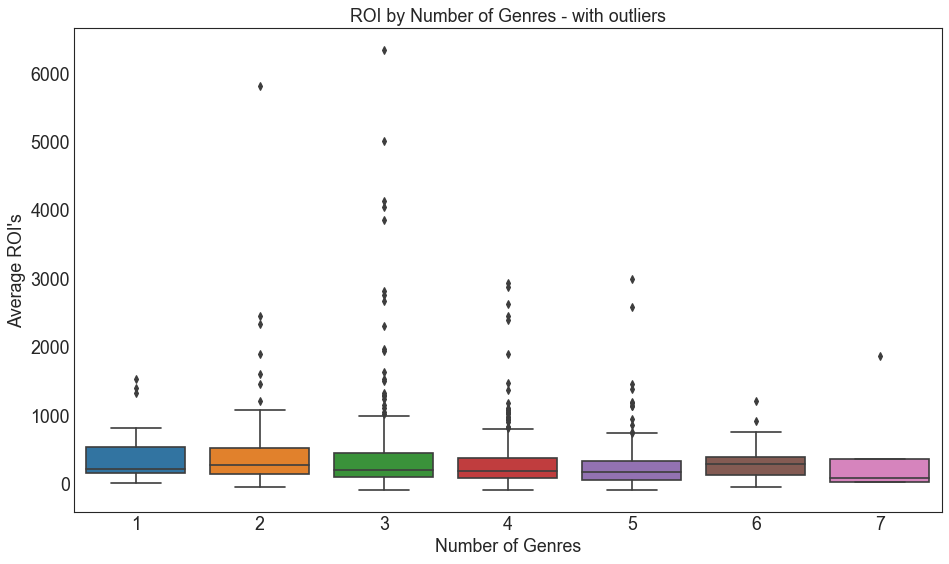

In [36]:
# Draw Plot

plt.figure(figsize=(14,8), dpi= 80)
sns.boxplot(x='genres_count', y='roi', data=final_df, notch=False)

# Add labels for x and y axes
plt.xlabel('Number of Genres')
plt.ylabel("Average ROI's")

# Add a title for the plot
plt.title('ROI by Number of Genres - with outliers')

plt.show()

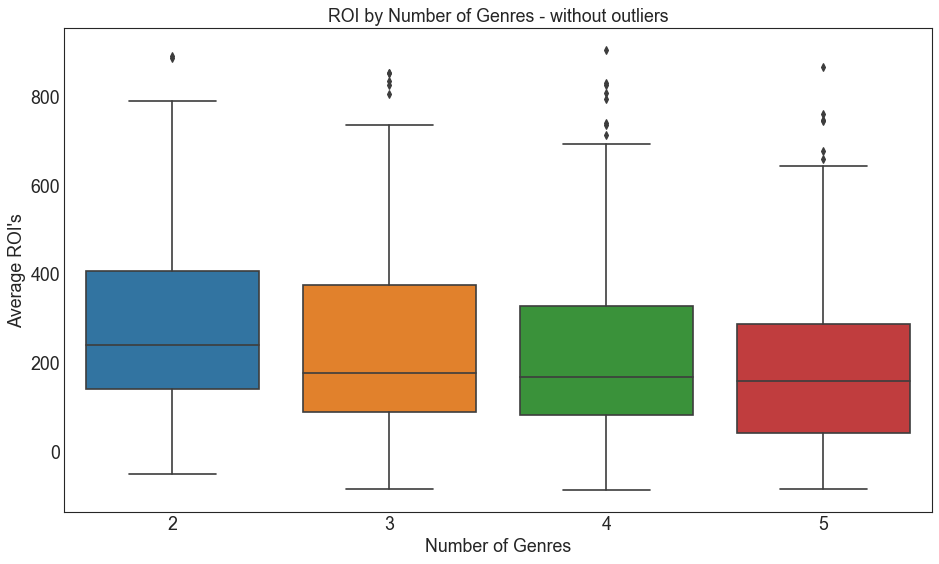

In [37]:
# col_to_filter = ['ROI', 'genre_count']
col_to_filter = ['roi','genres_count']
plot_df_filtered = iqr_data_filter(final_df, col_to_filter, 1.5)

# Draw Plot
plt.figure(figsize=(14,8), dpi= 80)
sns.boxplot(x='genres_count', y='roi', data=plot_df_filtered, notch=False)

# Add labels for x and y axes
plt.xlabel('Number of Genres')
plt.ylabel("Average ROI's")

# Add a title for the plot
plt.title('ROI by Number of Genres - without outliers')

plt.show()

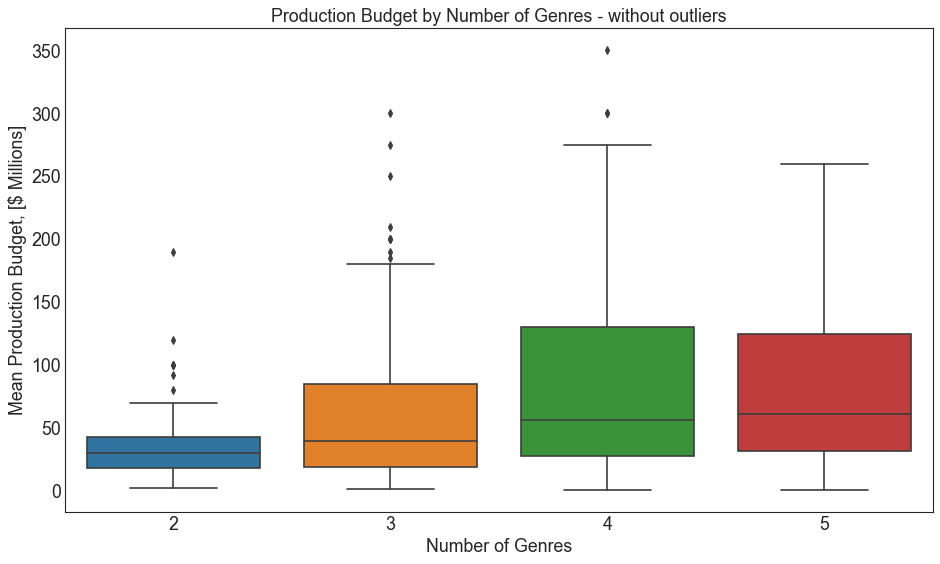

In [38]:
# Draw Plot
plt.figure(figsize=(14,8), dpi= 80)
sns.boxplot(x='genres_count', y='production_budget', data=plot_df_filtered, notch=False)

# Add labels for x and y axes
plt.xlabel('Number of Genres')
plt.ylabel("Mean Production Budget, [$ Millions]")

# Add a title for the plot
plt.title('Production Budget by Number of Genres - without outliers')

plt.show()

In [39]:
# Expanding the Genres Column

s = plot_df_filtered.apply(lambda x: pd.Series(x['genres']),
                           axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
plot_df_expanded = plot_df_filtered.drop('genres',axis=1).join(s)

plot_df_expanded.head()

,release_date,title,production_budget,domestic_gross,foreign_gross,worldwide_gross,roi,year,genres_count,genre
0,2010-01-08,Leap Year,19.0,25.918920,6.700000,32.618920,71.678526,2010,3,Romance
0,2010-01-08,Leap Year,19.0,25.918920,6.700000,32.618920,71.678526,2010,3,Comedy
0,2010-01-08,Leap Year,19.0,25.918920,6.700000,32.618920,71.678526,2010,3,Romantic Comedy
1,2010-01-11,The Book of Eli,80.0,94.835059,63.915758,158.750817,98.438521,2010,5,Science Fiction
1,2010-01-11,The Book of Eli,80.0,94.835059,63.915758,158.750817,98.438521,2010,5,Action


In [40]:
plot_df_expanded.describe()

,production_budget,domestic_gross,foreign_gross,worldwide_gross,roi,year,genres_count
count,2429.000000,2429.000000,2429.000000,2429.000000,2429.000000,2429.000000,2429.000000
mean,73.654196,89.018535,144.480463,235.902687,224.611799,2014.004117,3.927954
std,63.692366,103.373118,185.559869,282.190470,208.419825,2.594027,0.904044
min,1.000000,0.003200,0.003527,0.354836,-85.614037,2010.000000,2.000000
25%,25.000000,26.800000,27.271105,58.978653,75.871638,2012.000000,3.000000
50%,50.000000,53.262560,66.734085,128.955898,171.509370,2014.000000,4.000000
75%,110.000000,111.506430,193.141974,299.461782,327.840627,2016.000000,5.000000
max,350.000000,700.100000,1369.544272,2048.359754,904.055354,2019.000000,5.000000


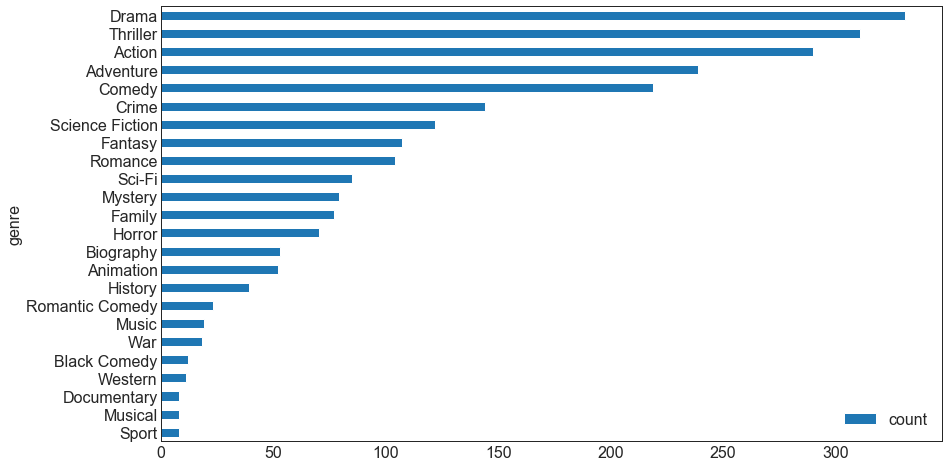

In [41]:
# What are the Most Common Genres?
common_genres = {}
common_genres['count'] = plot_df_expanded.groupby(['genre']).count()['genres_count']
common_genres = pd.DataFrame.from_dict(common_genres).sort_values( by ='count', ascending = True)

common_genres.plot.barh(figsize=(14,8))

<Figure size 2400x3200 with 0 Axes>

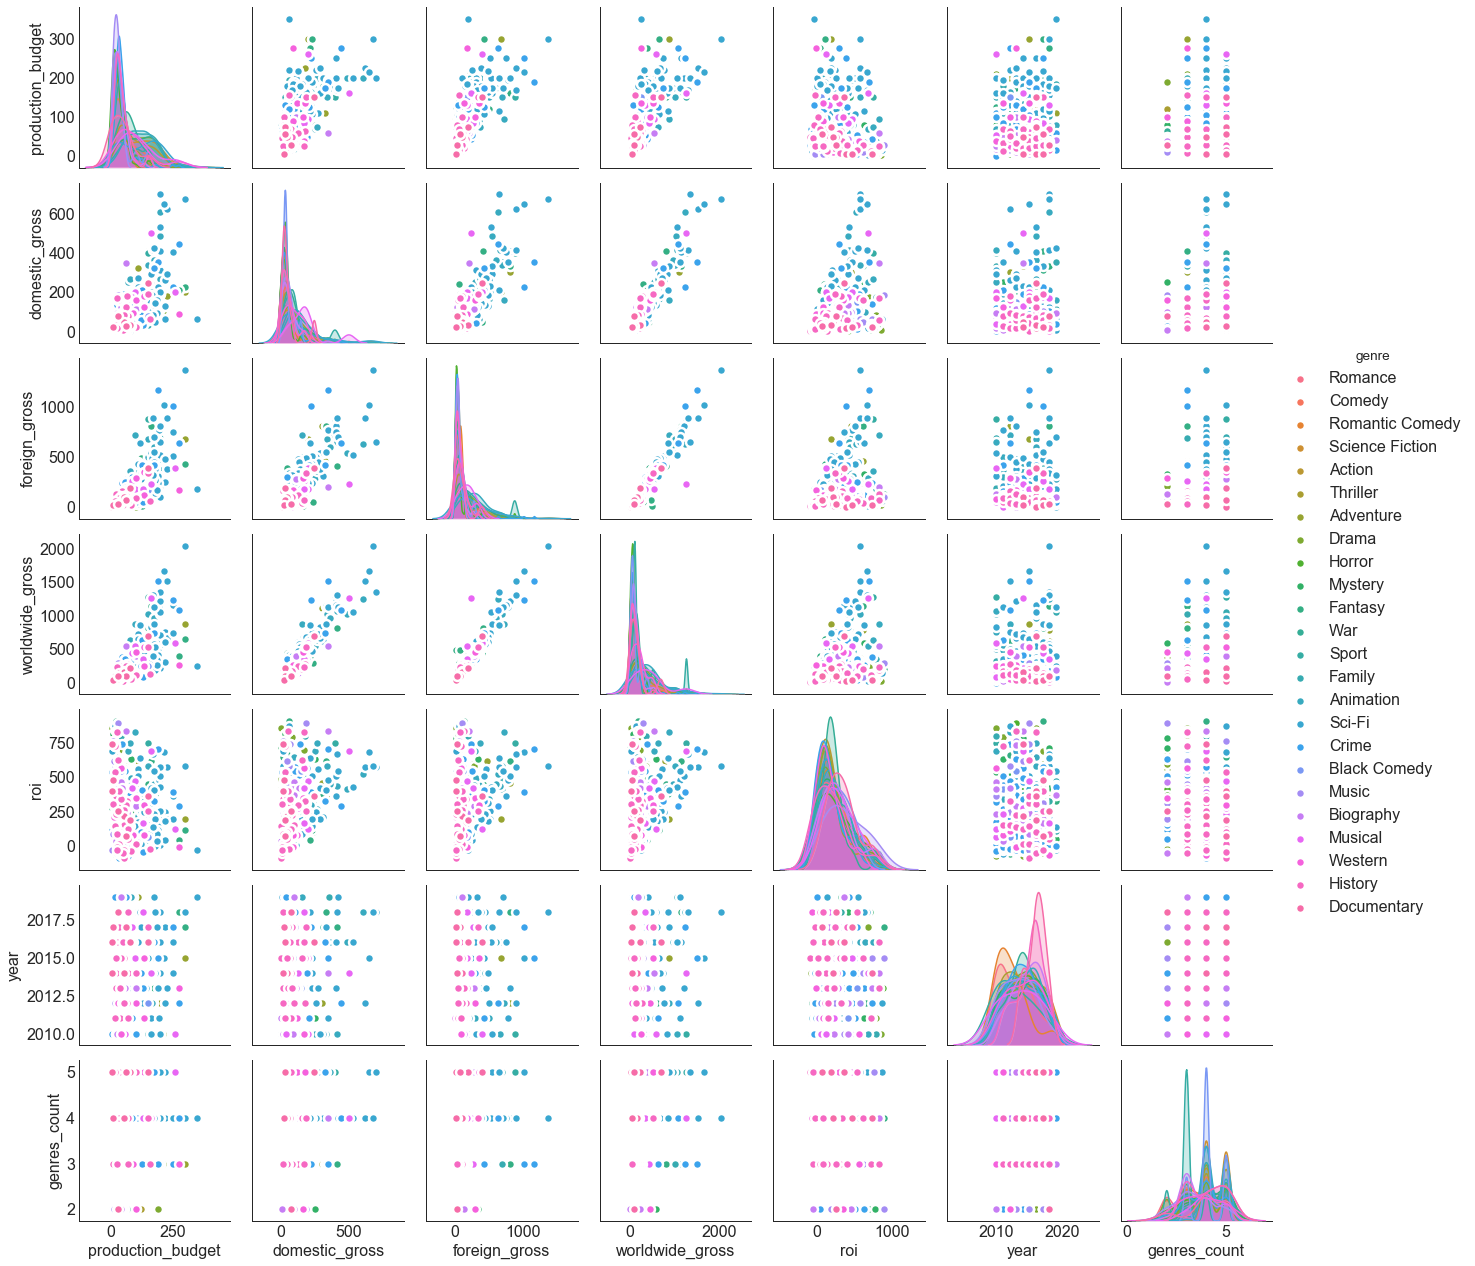

In [42]:
# General Overview of the Master DataFrame
plt.figure(figsize=(6,8), dpi= 400)
sns.pairplot(plot_df_expanded, kind="scatter", hue="genre",
             plot_kws=dict(s=80, edgecolor="white", linewidth=2.5))
plt.show()

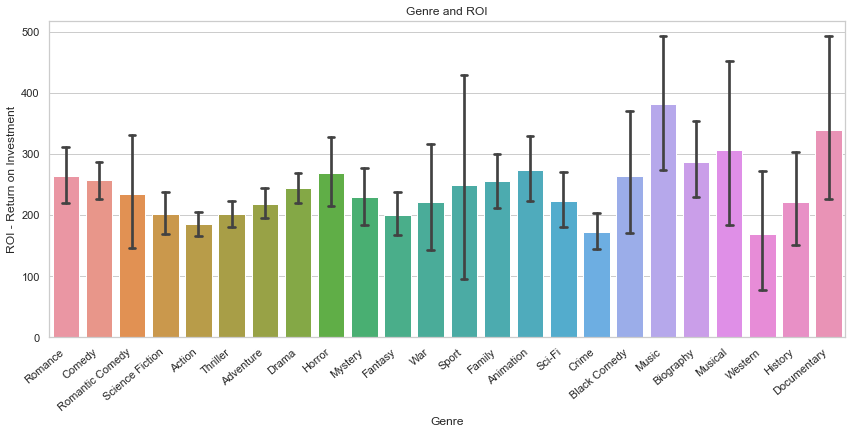

In [43]:
#Putting Data (above) in Context with Larger DataFrame
sns.set(style="whitegrid")
plt.figure(figsize=(12,6))
ax = sns.barplot(x="genre", y="roi", data=plot_df_expanded, capsize=.2)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()

# Add labels for x and y axes
plt.ylabel('ROI - Return on Investment')
plt.xlabel("Genre")

# Add a title for the plot
plt.title('Genre and ROI')

plt.show()

C:\Users\Jessica Yoon\anaconda3\lib\site-packages\numpy\lib\histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


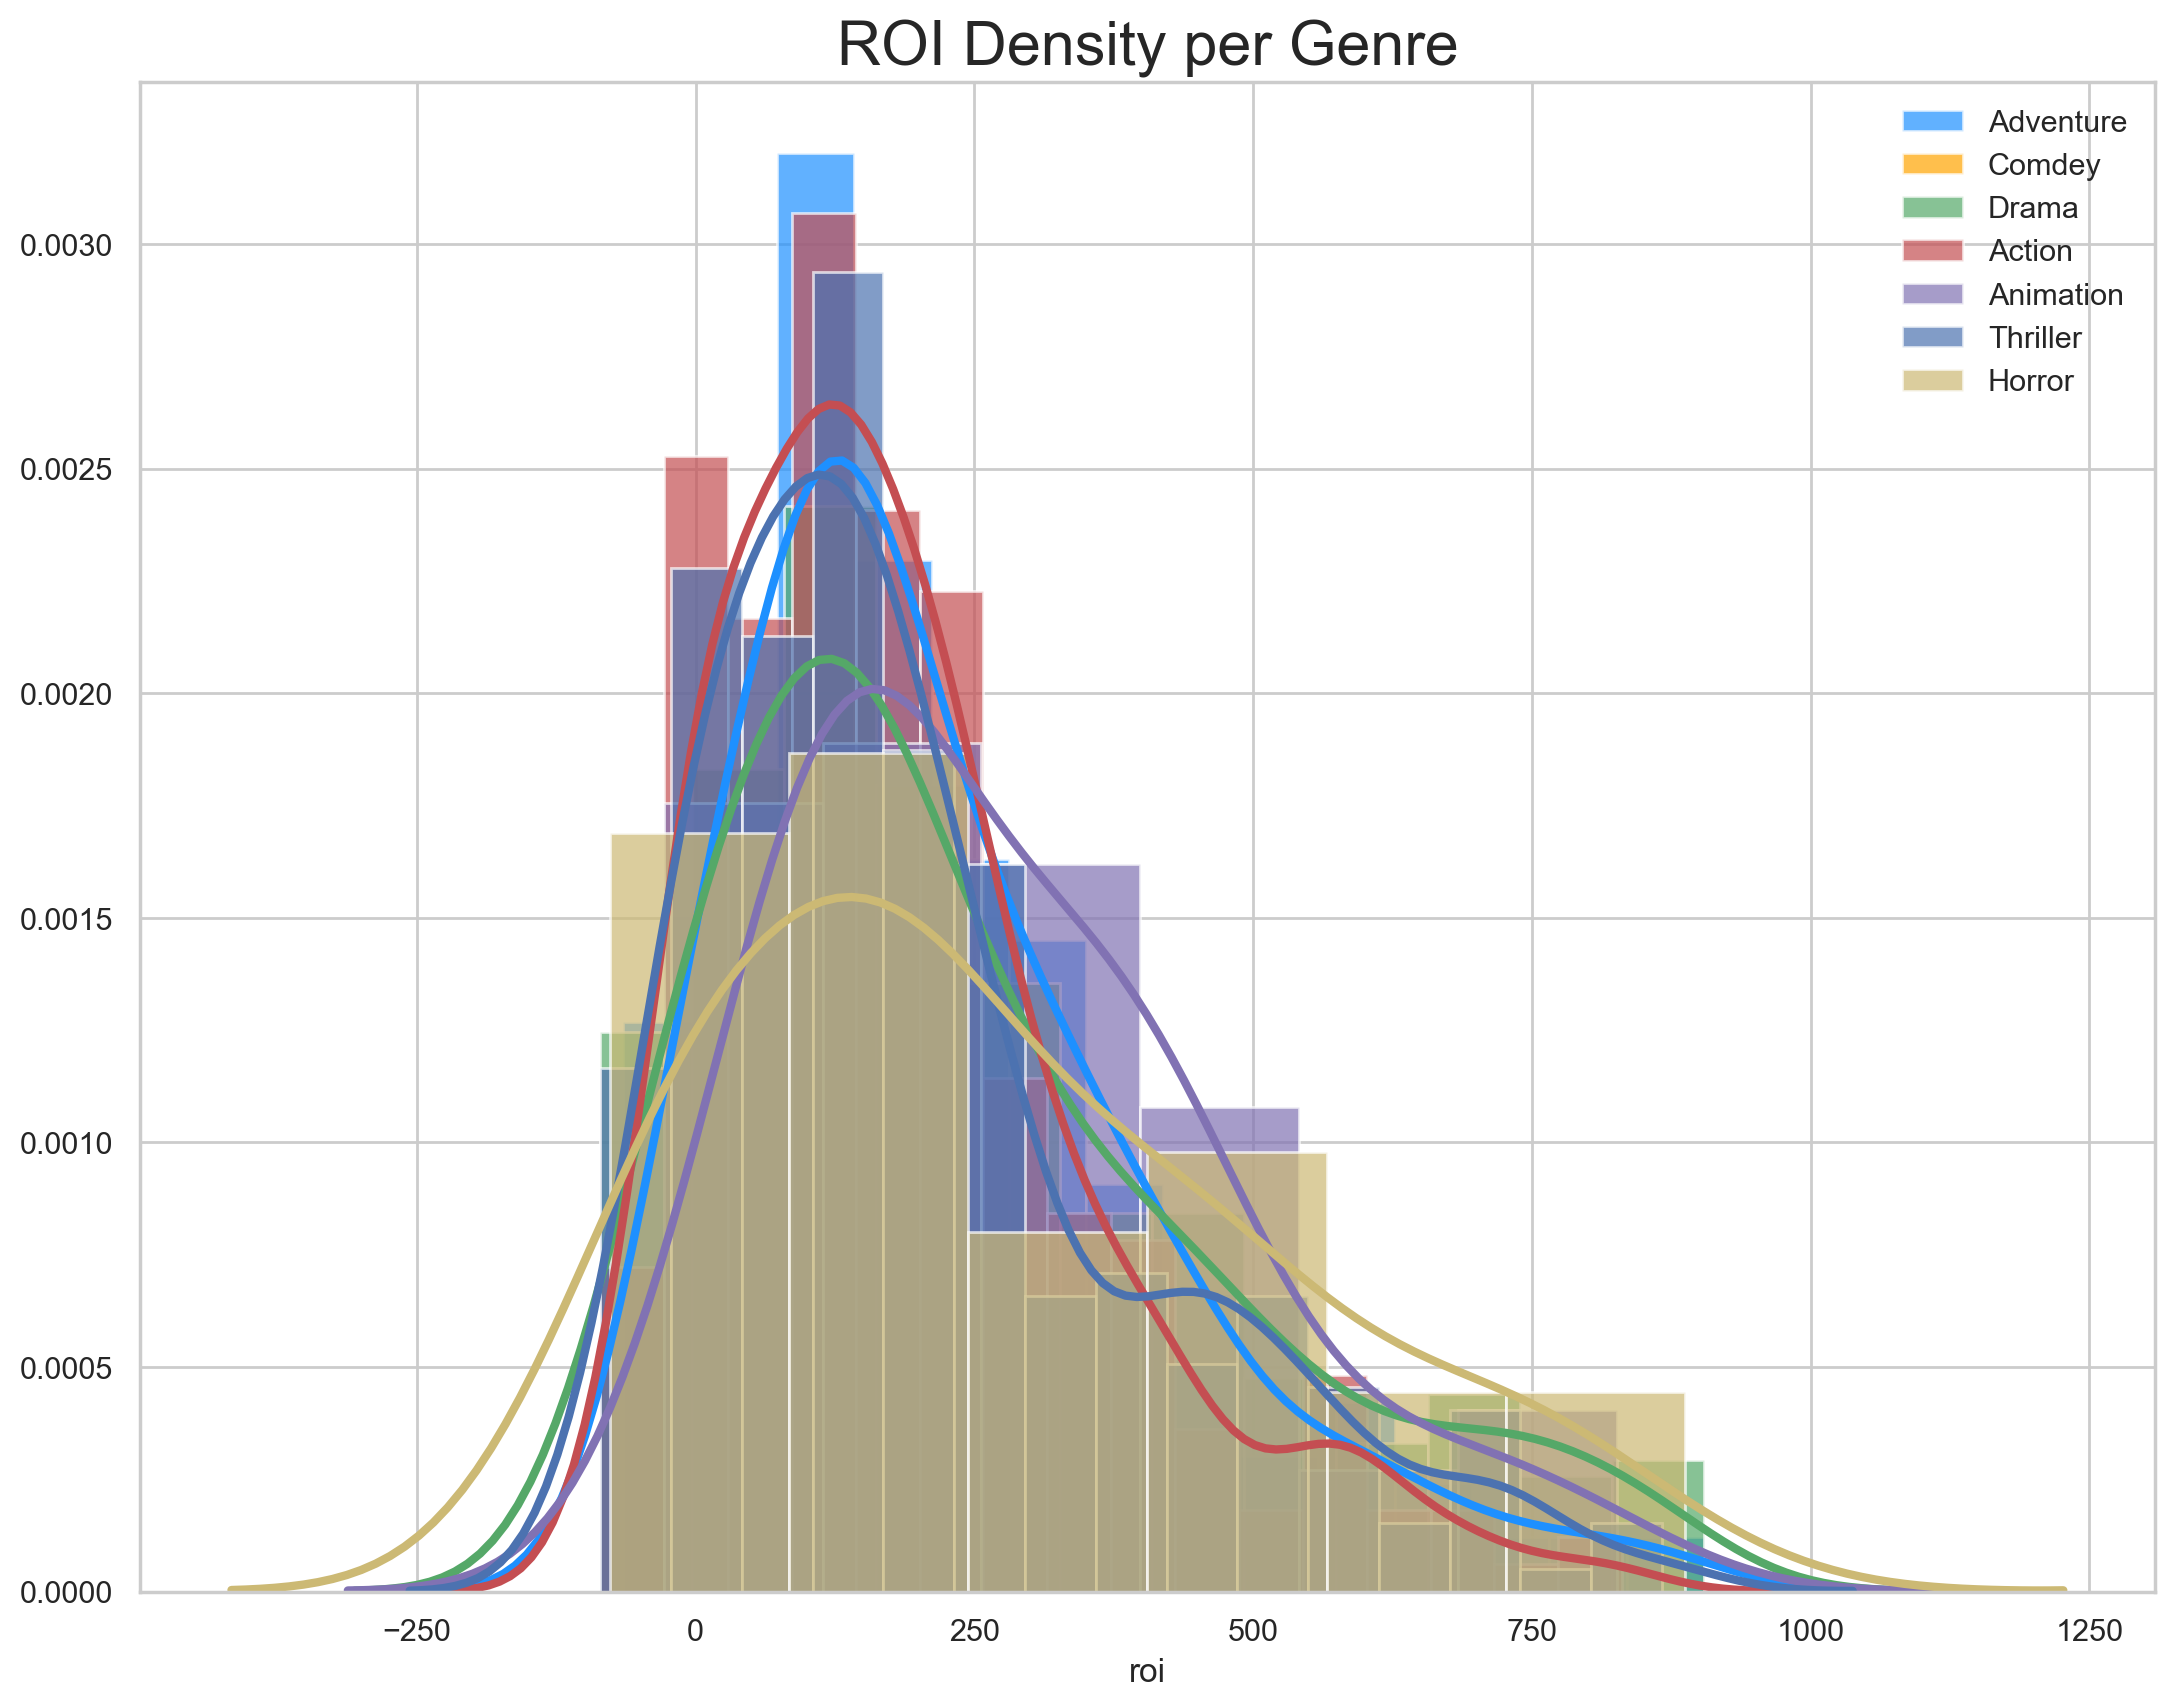

In [44]:
# Using Tables above to Analyze Density of the Highest ROI Genres

plt.figure(figsize=(13,10), dpi= 200)
genre_plot = ['Adventure','Comdey','Drama','Action','Animation',
              'Thriller','Horror']
colors = ['dodgerblue','orange','g','r','m','b','y']

for i in range(len(genre_plot)):
    sns.distplot(plot_df_expanded.loc[plot_df_expanded['genre'] == genre_plot[i], 
                                      "roi"], 
                 color = colors[i], 
                 label = genre_plot[i],
                 hist_kws={'alpha':.7}, 
                 kde_kws={'linewidth':3})

plt.title('ROI Density per Genre', fontsize=22)
plt.legend()
plt.show()

Text(0.5, 1.0, 'Trend of a genres ROI over last decade')

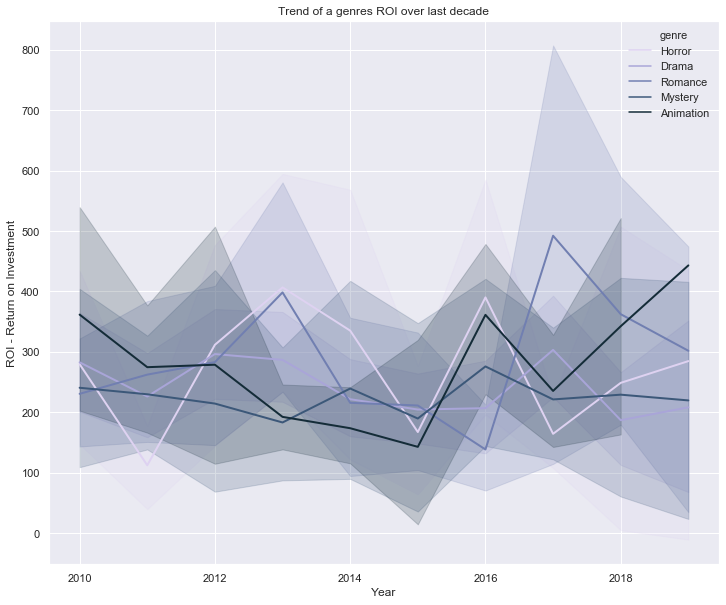

In [45]:
# Pulling Out Highest ROI Genres to Finalize Findings and Identify Trends
# Changing X to 'Year' to Better Display Changes Over Time 
sns.set(style="darkgrid")
plt.figure(figsize=(12,10))
sns.lineplot(x="year", y="roi",
             hue="genre", hue_order=['Horror', 'Drama', 'Romance', 'Mystery',
                                     'Animation'],
             estimator=np.mean, err_style="band", 
             data=plot_df_expanded, palette="ch:2.5,.25", linewidth=2.0)

# Add labels for x and y axes
plt.ylabel('ROI - Return on Investment')
plt.xlabel("Year")

# Add a title for the plot
plt.title('Trend of a genres ROI over last decade')

Text(0.5, 1.0, 'Trend of a genres ROI over last decade')

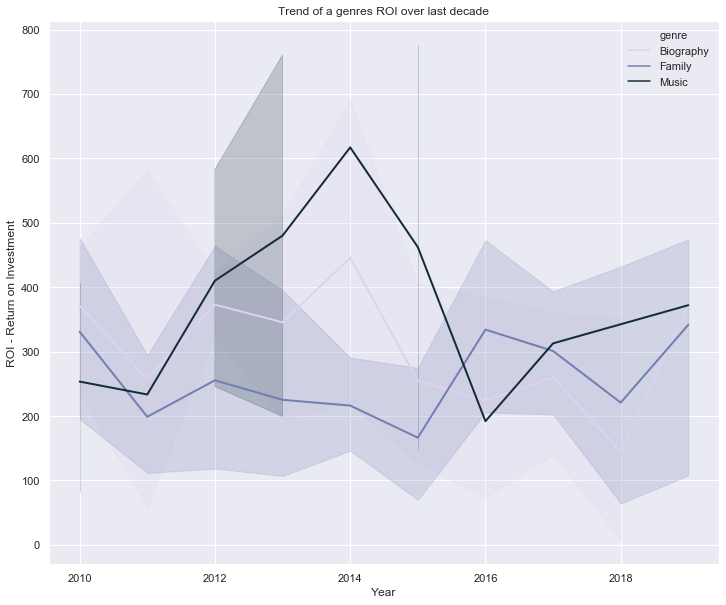

In [46]:
# Checking for Trends Across Other High ROI Genres
sns.set(style="darkgrid")
plt.figure(figsize=(12,10))
sns.lineplot(x="year", y="roi",
             hue="genre", hue_order=['Biography', 'Family', 'Music'],
             estimator=np.mean, err_style="band", 
             data=plot_df_expanded, palette="ch:2.5,.25", linewidth=2.0)

# Add labels for x and y axes
plt.ylabel('ROI - Return on Investment')
plt.xlabel("Year")

# Add a title for the plot
plt.title('Trend of a genres ROI over last decade')

Text(0.5, 1.0, 'Trend of a genres ROI over last decade')

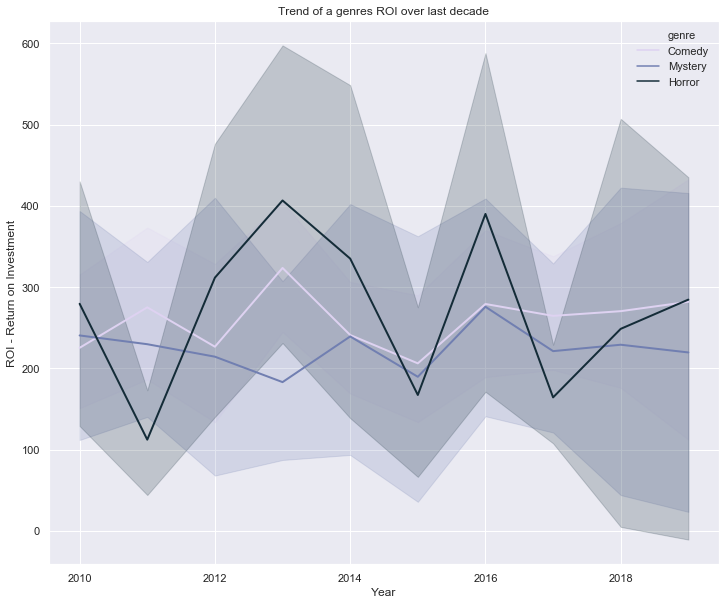

In [47]:
# Narrowing Selection
sns.set(style="darkgrid")
plt.figure(figsize=(12,10))
sns.lineplot(x="year", y="roi",
             hue="genre", hue_order=['Comedy', 'Mystery', 'Horror'],
             estimator=np.mean, err_style="band", 
             data=plot_df_expanded, palette="ch:2.5,.25", linewidth=2.0)

# Add labels for x and y axes
plt.ylabel('ROI - Return on Investment')
plt.xlabel("Year")

# Add a title for the plot
plt.title('Trend of a genres ROI over last decade')

Text(0.5, 1.0, 'Trend of a genres ROI over last decade')

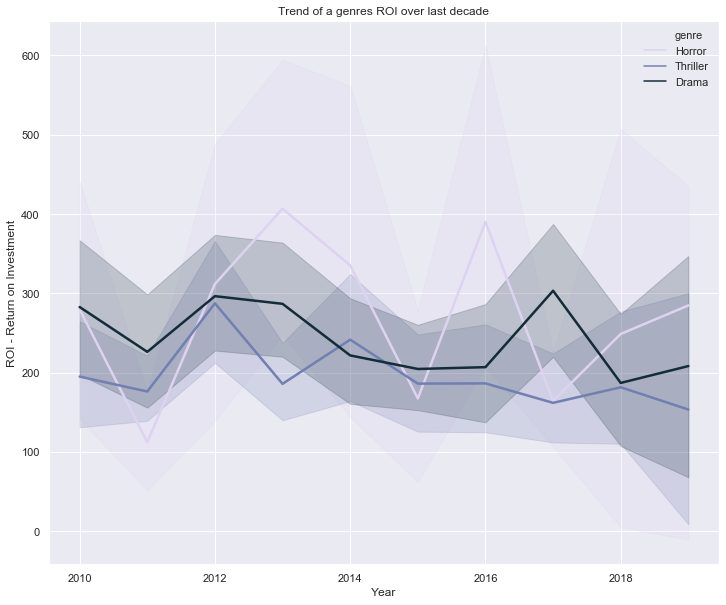

In [48]:
# Closing on the Top Trending Genres with Respect to ROI
sns.set(style="darkgrid")
plt.figure(figsize=(12,10))
sns.lineplot(x="year", y="roi",
             hue="genre", hue_order=['Horror', 'Thriller', 'Drama'],
             estimator=np.mean, err_style="band", 
             data=plot_df_expanded, palette="ch:2.5,.25", linewidth=2.5)

# Add labels for x and y axes
plt.ylabel('ROI - Return on Investment')
plt.xlabel("Year")

# Add a title for the plot
plt.title('Trend of a genres ROI over last decade')

Text(0.5, 1.0, 'Production Budget for Genres with the Highest ROI over Ten Years')

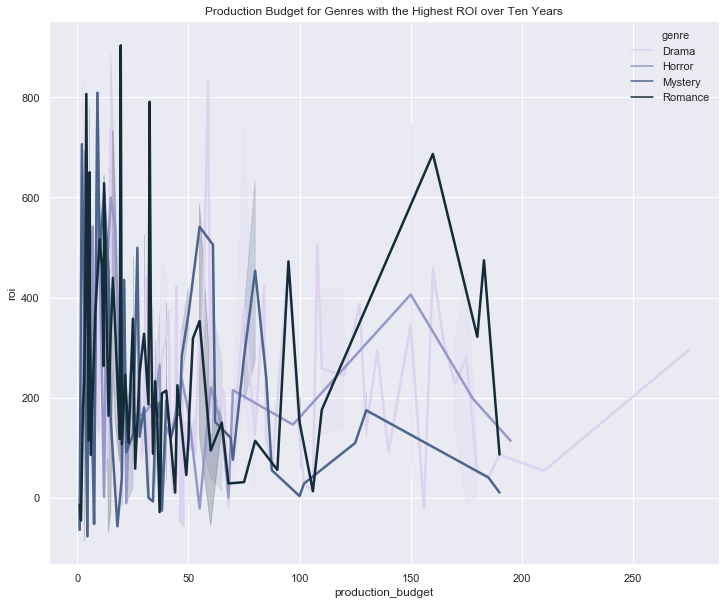

In [49]:
# Investigating Findings

sns.set(style="darkgrid")
plt.figure(figsize=(12,10))
sns.lineplot(x="production_budget", y="roi",
             hue="genre", hue_order=['Drama', 'Horror', 'Mystery', 'Romance'],
             estimator=np.mean, err_style="band", 
             data=plot_df_expanded, palette="ch:2.5,.25", linewidth=2.5)
plt.title('Production Budget for Genres with the Highest ROI over Ten Years')

Text(0.5, 1.0, 'Genres with the Highest ROI over Ten Years')

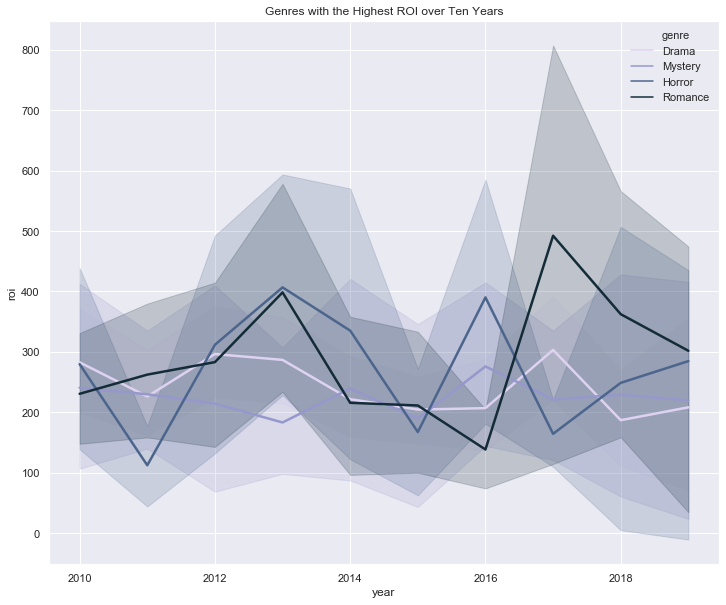

In [50]:
sns.set(style="darkgrid")
plt.figure(figsize=(12,10))
sns.lineplot(x="year", y="roi",
             hue="genre", hue_order=['Drama', 'Mystery', 'Horror', 'Romance'],
             estimator=np.mean, err_style="band", 
             data=plot_df_expanded, palette="ch:2.5,.25", linewidth=2.5)
plt.title('Genres with the Highest ROI over Ten Years')

# Jessica's

In [51]:
s = final_df.apply(lambda x: pd.Series(x['genres']),
                           axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
final_df_expanded = plot_df_filtered.drop('genres',axis=1).join(s)

final_df_expanded

,release_date,title,production_budget,domestic_gross,foreign_gross,worldwide_gross,roi,year,genres_count,genre
0,2010-01-08,Leap Year,19.0,25.918920,6.700000,32.618920,71.678526,2010,3,Romance
0,2010-01-08,Leap Year,19.0,25.918920,6.700000,32.618920,71.678526,2010,3,Comedy
0,2010-01-08,Leap Year,19.0,25.918920,6.700000,32.618920,71.678526,2010,3,Romantic Comedy
1,2010-01-11,The Book of Eli,80.0,94.835059,63.915758,158.750817,98.438521,2010,5,Science Fiction
1,2010-01-11,The Book of Eli,80.0,94.835059,63.915758,158.750817,98.438521,2010,5,Action
...,...,...,...,...,...,...,...,...,...,...
796,2019-09-17,Ad Astra,87.5,50.188370,85.243649,135.432019,54.779450,2019,5,Science Fiction
796,2019-09-17,Ad Astra,87.5,50.188370,85.243649,135.432019,54.779450,2019,5,Thriller
796,2019-09-17,Ad Astra,87.5,50.188370,85.243649,135.432019,54.779450,2019,5,Adventure
796,2019-09-17,Ad Astra,87.5,50.188370,85.243649,135.432019,54.779450,2019,5,Drama


In [52]:
# Creating Function for ROI
def roi (gross, budget):
    percentage = (gross-budget)/budget * 100
    return (percentage)

# Calculating ROI
final_df_expanded['domestic_roi'] = roi(final_df_expanded['domestic_gross'],
                                       final_df_expanded['production_budget'])
final_df_expanded['foreign_roi'] = roi(final_df_expanded['foreign_gross'],
                                      final_df_expanded['production_budget'])
final_df_expanded['worldwide_roi'] = roi(final_df_expanded['worldwide_gross'],
                                        final_df_expanded['production_budget'])

# Extracting the year
final_df_expanded['year'] = pd.DatetimeIndex(final_df_expanded['release_date']).year

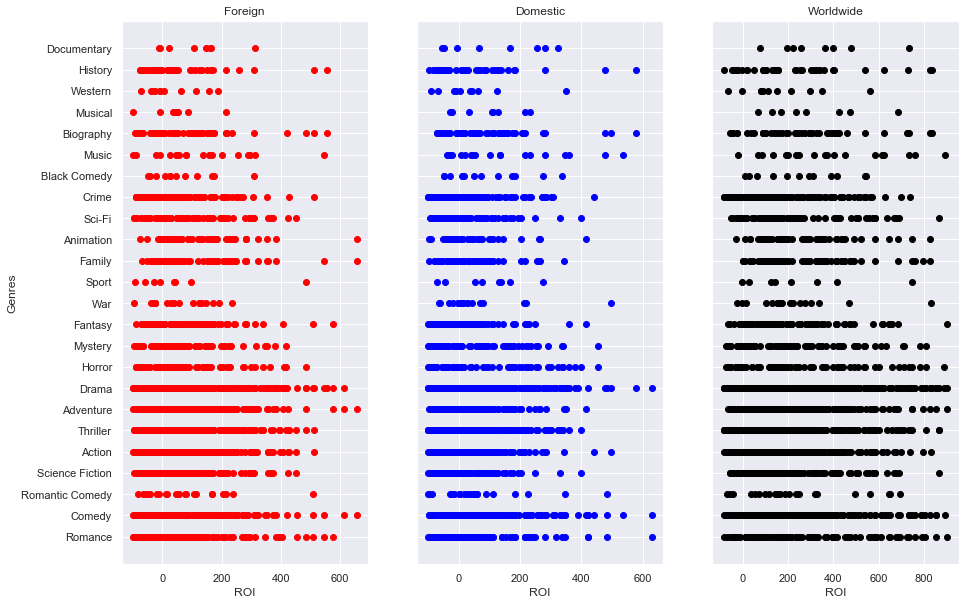

In [53]:
sns.set()

# Important Values
x = final_df_expanded['genre']
f = final_df_expanded['foreign_roi']
d = final_df_expanded['domestic_roi']
w = final_df_expanded['worldwide_roi']

# Create Figure and Subplots
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True, figsize =(15, 10))

# Plot
ax1.scatter(f, x, color='red')  
ax2.scatter(d, x, color='blue')
ax3.scatter(w, x, color='black')

# Title, X and Y labels
ax1.set_title('Foreign'); ax2.set_title('Domestic'); ax3.set_title('Worldwide');
ax1.set_xlabel('ROI');  ax2.set_xlabel('ROI'); ax3.set_xlabel('ROI');
ax1.set_ylabel('Genres');

# Output the final plot
plt.show()

In [54]:
# Comparing Average ROI Across Genres
averageroi = plot_df_expanded.groupby(['genre'], as_index=False).mean()
drop_columns = ['year', 'genres_count','worldwide_gross','production_budget',
                'domestic_gross','foreign_gross','roi']
averageroi = averageroi.drop(drop_columns, axis=1)
averageroi = averageroi.sort_values('worldwide_roi', ascending=True, 
                                    ignore_index=True)
averageroi.plot.barh(x='genre', width=1, figsize=(10,10))

KeyError: 'worldwide_roi'

In [ ]:
averageroi = averageroi.sort_values('domestic_roi', ignore_index=True)
averageroi.plot.barh(x='genre', width=1, figsize=(10,10))

In [ ]:
averageroi = averageroi.sort_values('foreign_roi', ignore_index=True)
averageroi.plot.barh(x='genre', width=1, figsize=(10,10))

# Nick's

In [ ]:
# Creating New Column to Find Evenly Distributed worldwide_gross of Movie 
# per Amount of Genres in Movie. 
plot_df_expanded['worldwide_gross_distributed'] = (
    plot_df_expanded['worldwide_gross'] / plot_df_expanded['genres_count'])
plot_df_expanded.head()

In [ ]:
# Group by 'Genre' and Sum Values of worldwide_gross_distribution
ww_gross = plot_df_expanded.groupby(['genre'], as_index=False).sum()

# Combining All Genres that Net Under $10 billion New Category 'Other'
ww_gross_filtered = ww_gross[ww_gross['worldwide_gross_distributed'] >= 5000]
ww_gross_others = ww_gross[ww_gross['worldwide_gross_distributed'] 
                           < 5000].sum().to_frame()

# Renaming Column
ww_gross_others[0][0] = 'Other'

# Merging Combined 'Other' Category to Main DataFrame
ww_gross_filtered = ww_gross_filtered.append(ww_gross_others.T, 
                                             ignore_index=True)

#Sort the value by 'worldwide_gross_distributed'
ww_gross_filtered = pd.DataFrame.from_dict(ww_gross_filtered).sort_values(
    by ='worldwide_gross_distributed', ascending = False)

#Drop all unneeded columns
ww_gross_filtered = ww_gross_filtered.drop(ww_gross_filtered.columns[1:-1], 
                                           axis=1)
ww_gross_filtered.head()

In [ ]:
# Pie Chart (Slices Ordered and Plotted Counter-clockwise)
labels = ww_gross_filtered['genre']
sizes = ww_gross_filtered['worldwide_gross_distributed']

explode = np.zeros(len(sizes))

# Exploding 'Action' and 'Adventure' Slices
explode[0:2] = .15

fig1, ax1 = plt.subplots(figsize=(4,4), dpi= 200)
ax1.pie(sizes, labels=labels, explode=explode,
        shadow=True, startangle = 50)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()